In [1]:
from google.colab import drive
%pip install ipython-sql sqlalchemy
%load_ext sql
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.7 MB/s eta 0:00:0000:0100:01


In [2]:
engine = create_engine('sqlite://')

id_url = '10z_YfPJpGPp33oJCYbbtHljPdvZF0drsurrKfOsjPoU'
url_excel = f'https://docs.google.com/spreadsheets/d/{id_url}/export?format=xlsx'
df = pd.read_excel(url_excel)
df.to_sql('database', con=engine, if_exists='replace', index=False)

%sql sqlite://

query_table = """ SELECT * 
FROM database
LIMIT 5;
"""

result_table = pd.read_sql_query(query_table, engine)
print(result_table.head())

   Day of TRX_DATE SHIP_TO_ID SALES_CHANNEL_DESC BRANCH_NAME  \
0  January 2, 2025  EPM_35002             Apotek   JAKARTA-1   
1  January 2, 2025  EPM_35683          Toko Obat   JAKARTA-1   
2  January 2, 2025  EPM_60781             Apotek   JAKARTA-1   
3  January 2, 2025  EPM_65685             Apotek      BEKASI   
4  January 2, 2025  EPM_76697             Apotek   JAKARTA-2   

  ORDER_CHANNEL (group)  TRX_NUMBER ITEM_CODE  GROSS_TRADE  DISC_TRADE  \
0                  EMOS   125000084    Item A        93603        3276   
1                  EMOS   125000061    Item A       187206        8424   
2                  EMOS   125000152    Item A       187206        8424   
3                  EMOS   125000196    Item B       105931        3178   
4                  EMOS   125000070    Item A        93603        3276   

   SALES_QTY  
0          3  
1          6  
2          6  
3          1  
4          3  


In [3]:
# info database
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58505 entries, 0 to 58504
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Day of TRX_DATE        58505 non-null  object
 1   SHIP_TO_ID             58505 non-null  object
 2   SALES_CHANNEL_DESC     58505 non-null  object
 3   BRANCH_NAME            58505 non-null  object
 4   ORDER_CHANNEL (group)  58505 non-null  object
 5   TRX_NUMBER             58505 non-null  int64 
 6   ITEM_CODE              58505 non-null  object
 7   GROSS_TRADE            58505 non-null  int64 
 8   DISC_TRADE             58505 non-null  int64 
 9   SALES_QTY              58505 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 4.5+ MB


,TRX_NUMBER,GROSS_TRADE,DISC_TRADE,SALES_QTY
count,5.850500e+04,5.850500e+04,58505.000000,58505.000000
mean,1.250316e+08,1.545717e+05,4581.327904,2.834954
std,2.482978e+04,1.995306e+05,9355.487899,4.020281
min,1.250000e+08,1.668600e+04,0.000000,1.000000
25%,1.250117e+08,6.065500e+04,1181.000000,1.000000
50%,1.250262e+08,1.059310e+05,2119.000000,2.000000
75%,1.250459e+08,1.872060e+05,4237.000000,3.000000
max,1.251246e+08,5.990592e+06,269577.000000,192.000000


In [4]:
# check duplicate
print(df.duplicated().sum())

0


In [5]:
# check missing value
print(df.isna().sum())

Day of TRX_DATE          0
SHIP_TO_ID               0
SALES_CHANNEL_DESC       0
BRANCH_NAME              0
ORDER_CHANNEL (group)    0
TRX_NUMBER               0
ITEM_CODE                0
GROSS_TRADE              0
DISC_TRADE               0
SALES_QTY                0
dtype: int64


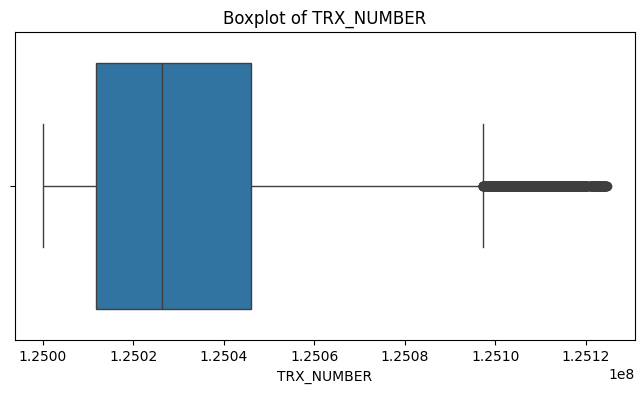

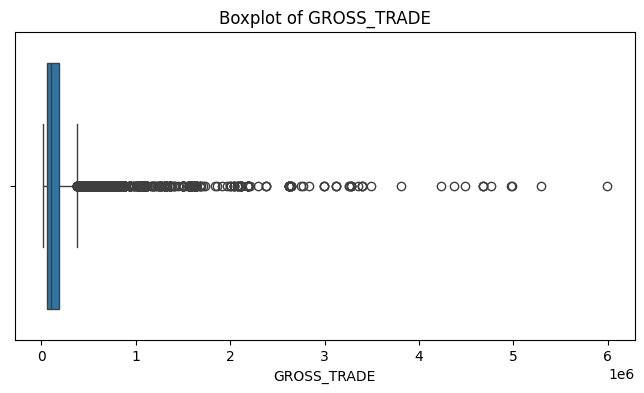

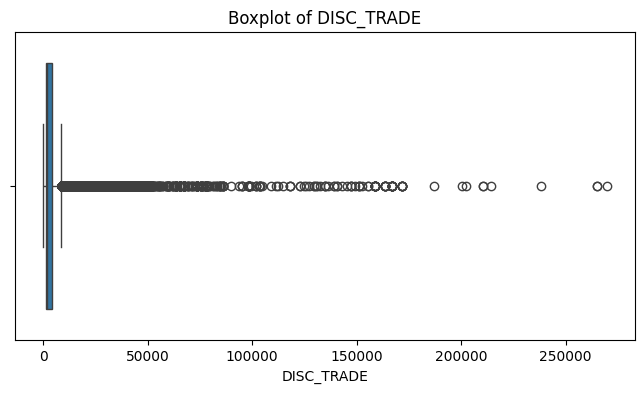

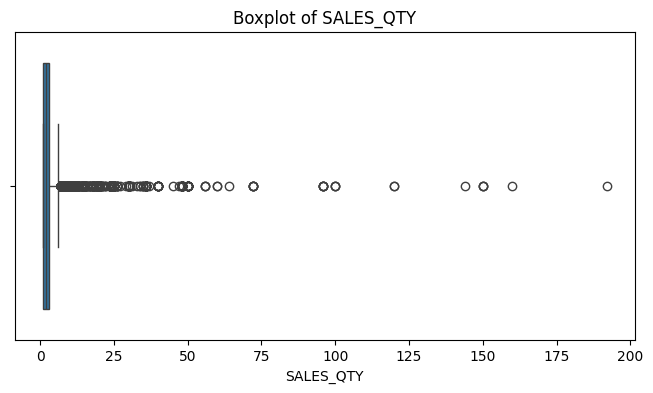

In [6]:
#check outlier per column
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[column])
    plt.title(f'Boxplot of {column}')
    plt.show()

#gk ada outlier

In [7]:
# cek logic outlier Gross Trade yang negatif

outlier_gross_trade = df[df['GROSS_TRADE'] < 0]
print(outlier_gross_trade)

Empty DataFrame
Columns: [Day of TRX_DATE, SHIP_TO_ID, SALES_CHANNEL_DESC, BRANCH_NAME, ORDER_CHANNEL (group), TRX_NUMBER, ITEM_CODE, GROSS_TRADE, DISC_TRADE, SALES_QTY]
Index: []


In [8]:
# cek logic outlier sales quantity yang negatif

outlier_sales_quantity = df[df['SALES_QTY'] <= 0]
print(outlier_sales_quantity)

Empty DataFrame
Columns: [Day of TRX_DATE, SHIP_TO_ID, SALES_CHANNEL_DESC, BRANCH_NAME, ORDER_CHANNEL (group), TRX_NUMBER, ITEM_CODE, GROSS_TRADE, DISC_TRADE, SALES_QTY]
Index: []


In [9]:
# price consistency check
df['Unit_Price'] = df['GROSS_TRADE'] / df['SALES_QTY']
price_check = df.groupby('ITEM_CODE')['Unit_Price'].agg(['min', 'max', 'mean'])
price_check['Variation'] = price_check['max'] - price_check['min']
anomalies = price_check[price_check['Variation'] > 1000].sort_values('Variation', ascending=False)

print(f"Ditemukan {len(anomalies)} Item dengan harga tidak konsisten:")
print(anomalies.head())

Ditemukan 8 Item dengan harga tidak konsisten:
                min       max           mean  Variation
ITEM_CODE                                              
Item P     264750.0  272693.0  269427.015968     7943.0
Item U     185500.0  189950.0  189171.857923     4450.0
Item H      57000.0   61000.0   58010.989011     4000.0
Item D      68000.0   70000.0   68303.372600     2000.0
Item M      53650.0   55250.0   54830.952381     1600.0


In [10]:
df['NET_SALES'] = df['GROSS_TRADE'] - df['DISC_TRADE']

     month  total_sales
0  2025-01   1557778732
1  2025-02   1531359653
2  2025-03   1828544717
3  2025-04   1221394057
4  2025-05   1540934258
5  2025-06   1363208493


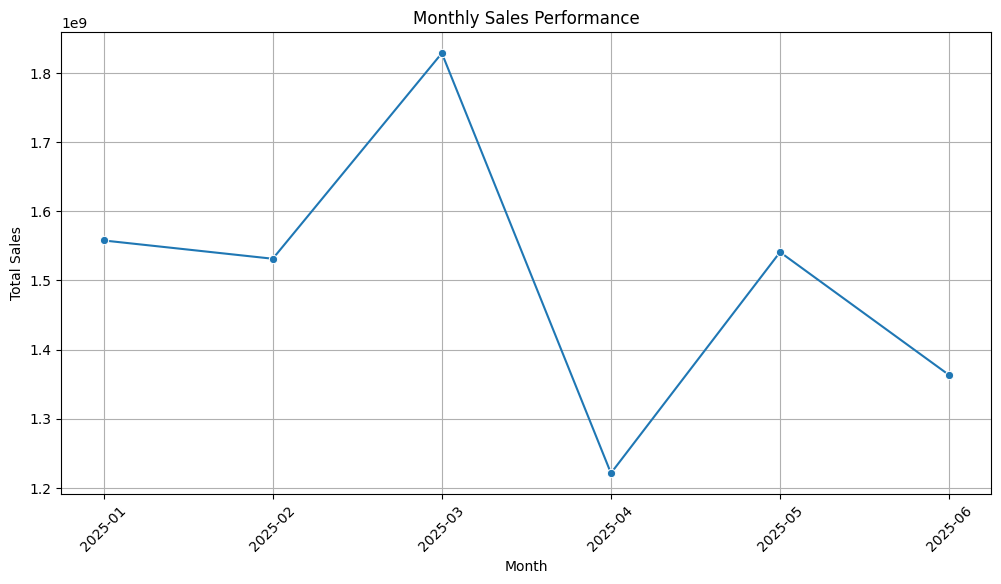

In [11]:
# sales performance month by month

df['TRX_DATE'] = pd.to_datetime(df['Day of TRX_DATE'])
df.to_sql('database', con=engine, if_exists='replace', index=False)

query_sales_performance = """
SELECT 
    strftime('%Y-%m', "TRX_DATE") AS month, 
    SUM(GROSS_TRADE) AS total_sales
FROM database
GROUP BY month
ORDER BY month;
"""

result_sales_performance = pd.read_sql_query(query_sales_performance, engine)
print(result_sales_performance)

plt.figure(figsize=(12, 6))
sns.lineplot(data=result_sales_performance, x='month', y='total_sales', marker='o')
plt.title('Monthly Sales Performance')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.xticks(rotation=45)
plt.grid()
plt.show()

        SALES_CHANNEL_DESC   net_sales
0                   Apotek  7672083218
1             Apotek Chain   593081543
2                   Klinik   113754649
3                RS Swasta    94639971
4        Toko Obat Berizin    86545383
5           Toko Kelontong    58414138
6   Pedagang Besar Farmasi    49292770
7                Toko Obat    44160920
8      Mini Market - Lokal    34100379
9            Toko Kosmetik    24483567
10                Koperasi     1972250
11                   Bidan     1218072
12               Baby Shop      743632
13               Toko Susu      226120
14              HybridMart      207625
15                   Hotel      207625
16    Tempat Makan & Minum       57459


/tmp/ipython-input-773187376.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_sales_channel, x='SALES_CHANNEL_DESC', y='net_sales', palette='viridis')


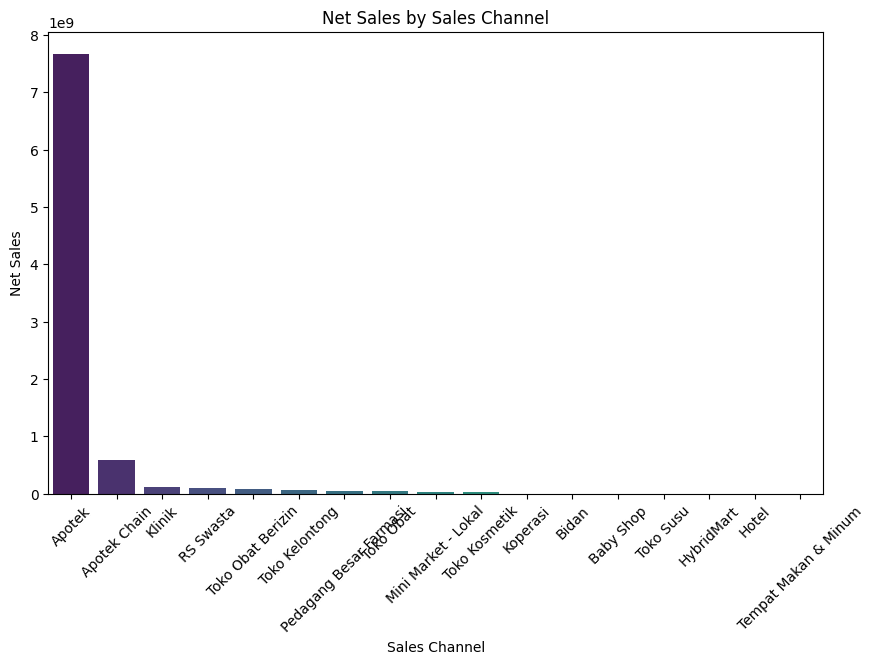

In [12]:
# perbandingan SALES_CHANNEL_DESC terhadap GROSS_TRADE - DISC_TRADE

query_sales_channel = """
SELECT
    SALES_CHANNEL_DESC,
    SUM(GROSS_TRADE - DISC_TRADE) AS net_sales
FROM database
GROUP BY SALES_CHANNEL_DESC
ORDER BY net_sales DESC;
"""

result_sales_channel = pd.read_sql_query(query_sales_channel, engine)
print(result_sales_channel)

plt.figure(figsize=(10, 6))
sns.barplot(data=result_sales_channel, x='SALES_CHANNEL_DESC', y='net_sales', palette='viridis')
plt.title('Net Sales by Sales Channel')
plt.xlabel('Sales Channel')
plt.ylabel('Net Sales')
plt.xticks(rotation=45)
plt.show()

         BRANCH_NAME  net_sales
0            BANDUNG  603244354
1           MAKASSAR  447919625
2          TANGERANG  408882287
3          JAKARTA-2  382331452
4              DEPOK  356774765
5           DENPASAR  346135133
6          SAMARINDA  334272408
7     BANDAR LAMPUNG  308810471
8          PALEMBANG  301209444
9        BANJARMASIN  280222663
10        YOGYAKARTA  268967982
11            BEKASI  245895517
12           PEJATEN  214019621
13         JAKARTA-1  211236284
14         PONTIANAK  209957639
15          SEMARANG  183893768
16            MALANG  178793976
17             BOGOR  176273945
18        BALIKPAPAN  175836599
19        SURABAYA-2  168974341
20            MANADO  156753429
21           MATARAM  152676625
22              SOLO  152130611
23        SURABAYA-1  149132873
24          SUKABUMI  147137859
25            PADANG  137982811
26           CIREBON  137872241
27        PEKAN BARU  135466246
28            JEMBER  134406570
29          BENGKULU  131217412
30      

/tmp/ipython-input-1195474445.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_branch_performance, x='BRANCH_NAME', y='net_sales', palette='magma')


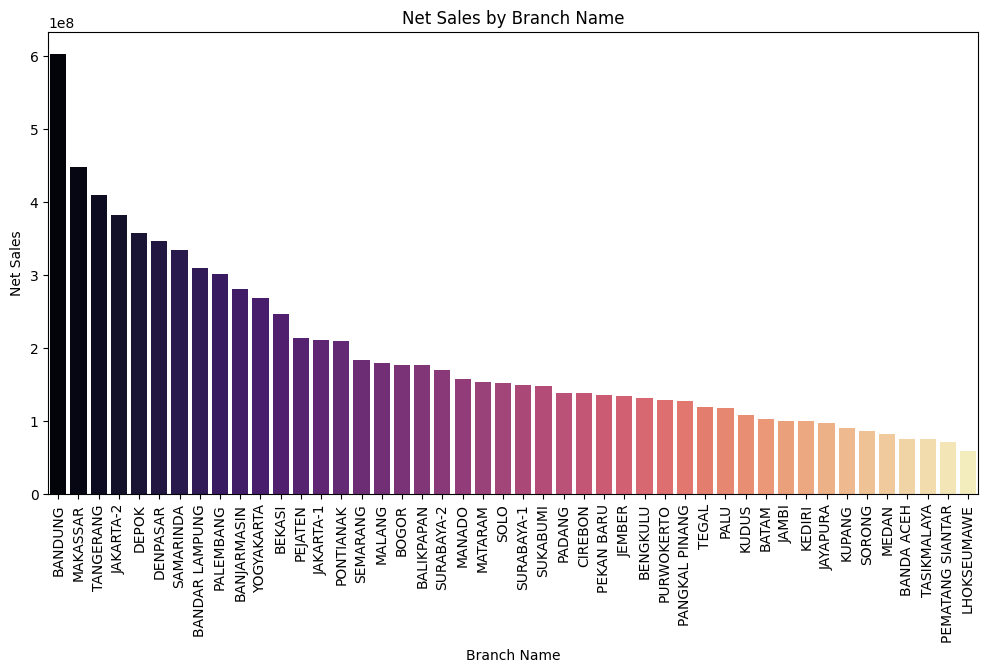

In [13]:
# performance per BRANCH_NAME terhadap GROSS_TRADE - DISC_TRADE

query_branch_performance = """
SELECT
    BRANCH_NAME,
    SUM(GROSS_TRADE - DISC_TRADE) AS net_sales
FROM database
GROUP BY BRANCH_NAME
ORDER BY net_sales DESC;
"""

result_branch_performance = pd.read_sql_query(query_branch_performance, engine)
print(result_branch_performance)

plt.figure(figsize=(12, 6))
sns.barplot(data=result_branch_performance, x='BRANCH_NAME', y='net_sales', palette='magma')
plt.title('Net Sales by Branch Name')
plt.xlabel('Branch Name')
plt.ylabel('Net Sales')
plt.xticks(rotation=90)
plt.show()

   ITEM_CODE   net_sales  total_quantity
0     Item C  2399124000           21970
1     Item A  1386291631           44431
2     Item D  1354262000           19832
3     Item B  1063123516           10036
4     Item P   431871244            1604
5     Item G   351457218           21063
6     Item E   309442658           10717
7     Item F   300959568            5096
8     Item M   284965600            5200
9     Item I   193323823            5731
10    Item O   107691528            2154
11    Item J   106835000            4645
12    Item R   105175770            1734
13    Item Q    95598500            2858
14    Item L    91109925            1535
15    Item N    89951365            1483
16    Item V    88992750             402
17    Item S    67220377            1304
18    Item K    62825562            2022
19    Item T    60412380             996
20    Item H    46453000             801
21    Item U    45586600             241
22    Item W      506913               3
23    Item X    

/tmp/ipython-input-1706985855.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=result_product_performance, x='ITEM_CODE', y='net_sales', palette='coolwarm')


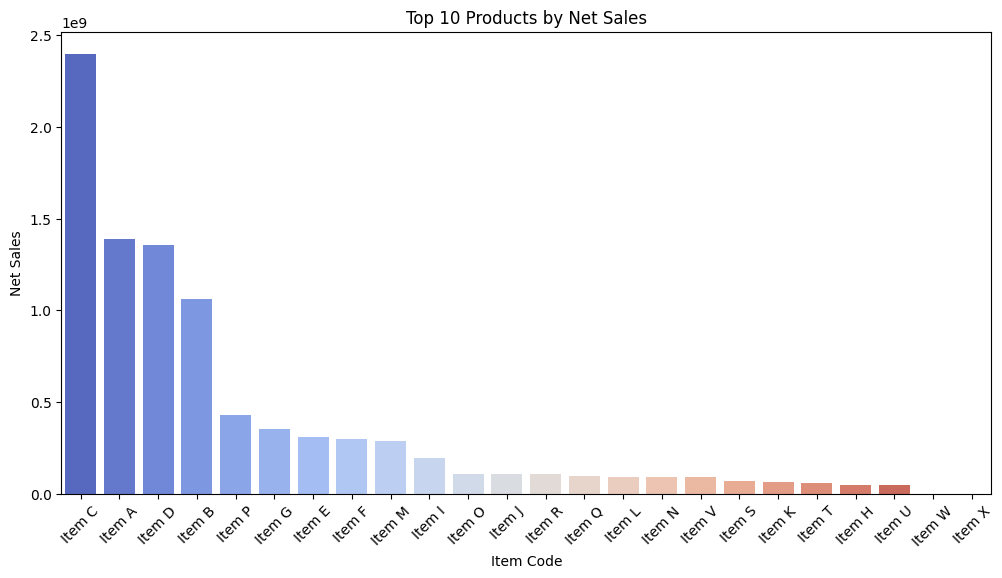

In [14]:
# product performance per ITEM_CODE terhadap net sales dan SALES_QTY

query_product_performance = """
SELECT
    ITEM_CODE,
    SUM(GROSS_TRADE) AS net_sales,
    SUM(SALES_QTY) AS total_quantity
FROM database
GROUP BY ITEM_CODE
ORDER BY net_sales DESC;
"""

result_product_performance = pd.read_sql_query(query_product_performance, engine)
print(result_product_performance)

plt.figure(figsize=(12, 6))
sns.barplot(data=result_product_performance, x='ITEM_CODE', y='net_sales', palette='coolwarm')
plt.title('Top 10 Products by Net Sales')
plt.xlabel('Item Code')
plt.ylabel('Net Sales')
plt.xticks(rotation=45)
plt.show()

   unique_customers
0              9882
   total_repeat_customers
0                    7106


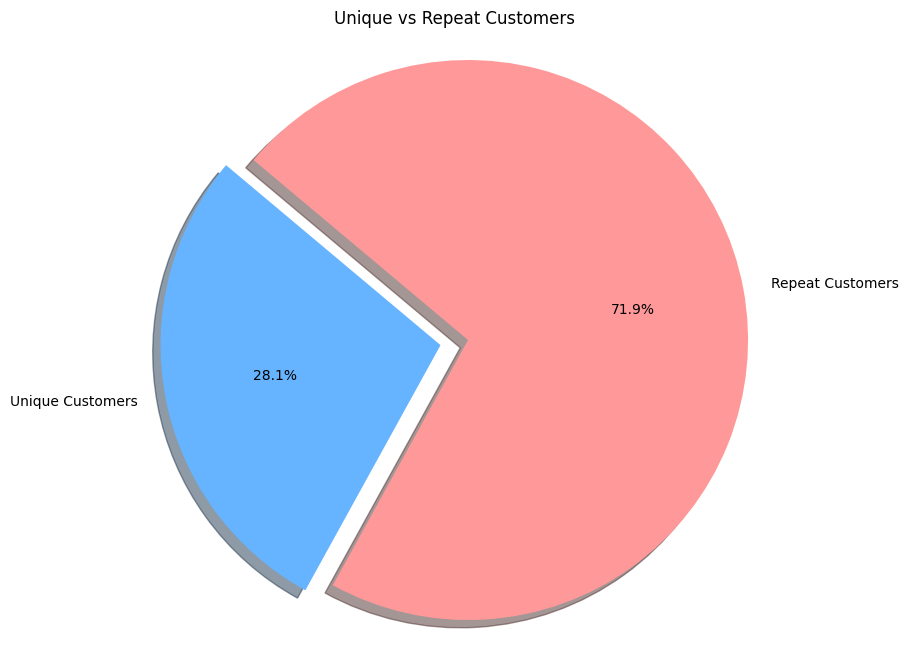

In [15]:
# customer yang repeat order

query_count_unique_customers = """
SELECT
    COUNT(DISTINCT SHIP_TO_ID) AS unique_customers
FROM database;
"""

result_unique_customers = pd.read_sql_query(query_count_unique_customers, engine)
print(result_unique_customers)

#---------

query_count_repeat_orders = """
SELECT COUNT(*) AS total_repeat_customers
FROM (
    SELECT SHIP_TO_ID
    FROM database
    GROUP BY SHIP_TO_ID
    HAVING COUNT(*) > 1
) t;
"""

result_repeat_orders = pd.read_sql_query(query_count_repeat_orders, engine)
print(result_repeat_orders)

# visualization unique vs repeat customers

labels = ['Unique Customers', 'Repeat Customers']
sizes = [result_unique_customers['unique_customers'][0] - result_repeat_orders['total_repeat_customers'][0], result_repeat_orders['total_repeat_customers'][0]]
colors = ['#66b3ff', '#ff9999']
explode = (0.1, 0)
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Unique vs Repeat Customers')
plt.axis('equal')
plt.show()

In [16]:
query_rfm = """
WITH CleanedData AS (
    SELECT 
        SHIP_TO_ID,
        TRX_NUMBER,
        TRX_DATE, -- Pastikan kolom ini sudah format YYYY-MM-DD
        -- Membersihkan format uang (hapus koma) dan ubah ke angka float
        CAST(REPLACE(GROSS_TRADE, ',', '') AS FLOAT) as gross_clean,
        CAST(REPLACE(DISC_TRADE, ',', '') AS FLOAT) as disc_clean
    FROM database
),

RFM_Values AS (
    SELECT 
        SHIP_TO_ID,
        -- Recency: Menghitung selisih hari dari '2025-07-01' ke transaksi terakhir
        CAST(julianday('2025-07-01') - julianday(MAX(TRX_DATE)) AS INTEGER) as Recency,
        
        -- Frequency: Menghitung jumlah transaksi unik (bukan jumlah baris item)
        COUNT(DISTINCT TRX_NUMBER) as Frequency,
        
        -- Monetary: Menghitung total belanja bersih (Gross - Disc)
        SUM(gross_clean - disc_clean) as Monetary
    FROM CleanedData
    GROUP BY SHIP_TO_ID
),

RFM_Scores AS (
    SELECT 
        *,
        -- Scoring 1-5 menggunakan Window Function NTILE
        
        -- Recency: Kita urutkan DESC (Besar ke Kecil). 
        -- Logika: Hari besar (lama gak beli) dapat skor 1. Hari kecil (baru beli) dapat skor 5.
        NTILE(5) OVER (ORDER BY Recency DESC) as R_Score,
        
        -- Frequency: Urutkan ASC. Beli sedikit skor 1, Beli banyak skor 5.
        NTILE(5) OVER (ORDER BY Frequency ASC) as F_Score,
        
        -- Monetary: Urutkan ASC. Belanja dikit skor 1, Belanja banyak skor 5.
        NTILE(5) OVER (ORDER BY Monetary ASC) as M_Score
    FROM RFM_Values
)

SELECT 
    *,
    -- Gabungkan Score jadi satu string, misal '555' (Champions)
    R_Score || F_Score || M_Score as RFM_Cell,
    
    -- Logic Segmentation Sederhana
    CASE 
        WHEN R_Score >= 4 AND F_Score >= 4 AND M_Score >= 4 THEN 'Champions'
        WHEN R_Score >= 3 AND F_Score >= 3 AND M_Score >= 3 THEN 'Loyal Customers'
        WHEN R_Score >= 3 AND F_Score <= 2 THEN 'Potential Loyalist'
        WHEN R_Score <= 2 AND F_Score >= 3 THEN 'At Risk'
        WHEN R_Score <= 2 AND F_Score <= 2 THEN 'Hibernating'
        ELSE 'Others'
    END as Customer_Segment
FROM RFM_Scores
ORDER BY Monetary DESC;
"""

# Eksekusi Query
df_rfm = pd.read_sql_query(query_rfm, engine)

# Tampilkan Hasil
print(df_rfm[['SHIP_TO_ID', 'Recency', 'Frequency', 'Monetary', 'Customer_Segment']].head(10))
print("\n--- Jumlah Customer per Segment ---")
print(df_rfm['Customer_Segment'].value_counts())

    SHIP_TO_ID  Recency  Frequency    Monetary Customer_Segment
0  EPM_3453329        7         29  75790989.0        Champions
1  EPM_4859446        1         77  30585940.0        Champions
2  EPM_3384321        5         27  27480407.0        Champions
3  EPM_4393399        1         42  25273614.0        Champions
4  EPM_4365199        6         52  24923131.0        Champions
5    EPM_94391        1         20  24215383.0        Champions
6  EPM_1308639        1         47  24089242.0        Champions
7  EPM_3357856        1        141  23216817.0        Champions
8  EPM_4538016        1         37  23037229.0        Champions
9  EPM_4109855        1         32  21813973.0        Champions

--- Jumlah Customer per Segment ---
Customer_Segment
Hibernating           2571
Champions             2244
Loyal Customers       2041
At Risk               1383
Potential Loyalist    1383
Others                 260
Name: count, dtype: int64


/tmp/ipython-input-1493125181.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rfm, x='Customer_Segment', order=df_rfm['Customer_Segment'].value_counts().index, palette='Set2')


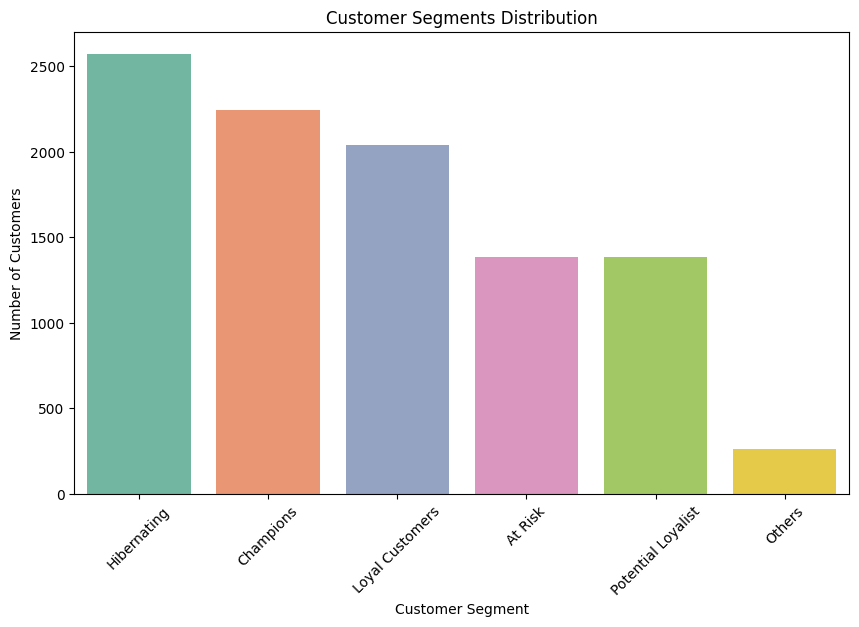

In [17]:
# visualisasi rfm segments dengan bar chart

plt.figure(figsize=(10, 6))
sns.countplot(data=df_rfm, x='Customer_Segment', order=df_rfm['Customer_Segment'].value_counts().index, palette='Set2')
plt.title('Customer Segments Distribution')
plt.xlabel('Customer Segment')
plt.ylabel('Number of Customers')
plt.xticks(rotation=45)
plt.show()

In [18]:
query_discount = """
WITH CleanedData AS (
    SELECT 
        TRX_NUMBER,
        -- Bersihkan format uang (hapus koma)
        CAST(REPLACE(GROSS_TRADE, ',', '') AS FLOAT) as Gross_Trade,
        CAST(REPLACE(DISC_TRADE, ',', '') AS FLOAT) as Disc_Trade,
        SALES_QTY
    FROM database
),

CalculatedData AS (
    SELECT 
        TRX_NUMBER,
        Gross_Trade,
        Disc_Trade,
        (Gross_Trade - Disc_Trade) as Net_Sales,
        SALES_QTY,
        -- Hitung Persentase Diskon (Rumus: Diskon / Harga Awal * 100)
        CASE 
            WHEN Gross_Trade = 0 THEN 0 
            ELSE (Disc_Trade / Gross_Trade) * 100 
        END as Disc_Pct
    FROM CleanedData
),

DiscBuckets AS (
    SELECT 
        *,
        -- Kelompokkan Diskon ke dalam Bucket
        CASE 
            WHEN Disc_Pct <= 0 THEN '0%'
            WHEN Disc_Pct > 0 AND Disc_Pct <= 1 THEN '0-1%'
            WHEN Disc_Pct > 1 AND Disc_Pct <= 2 THEN '1-2%'
            WHEN Disc_Pct > 2 AND Disc_Pct <= 5 THEN '2-5%'
            WHEN Disc_Pct > 5 AND Disc_Pct <= 10 THEN '5-10%'
            ELSE '>10%'
        END as Disc_Group
    FROM CalculatedData
)

SELECT 
    Disc_Group,
    -- Jumlah Transaksi di level diskon ini
    COUNT(DISTINCT TRX_NUMBER) as Total_Trx,
    
    -- Rata-rata Nilai Belanja (Apakah makin besar diskon, belanja makin besar?)
    AVG(Net_Sales) as Avg_Trx_Value,
    
    -- Rata-rata Jumlah Barang (Qty)
    AVG(SALES_QTY) as Avg_Qty,
    
    -- Total Omzet dari grup ini
    SUM(Net_Sales) as Total_Revenue
FROM DiscBuckets
GROUP BY Disc_Group
ORDER BY 
    -- Urutkan bucket agar rapi (0% -> >10%)
    CASE Disc_Group
        WHEN '0%' THEN 1
        WHEN '0-1%' THEN 2
        WHEN '1-2%' THEN 3
        WHEN '2-5%' THEN 4
        WHEN '5-10%' THEN 5
        ELSE 6
    END;
"""

# Eksekusi dan Tampilkan dengan Format Rupiah
df_disc = pd.read_sql_query(query_discount, engine)

# Formatting agar mudah dibaca
df_disc.style.format({
    'Avg_Trx_Value': "Rp {:,.0f}",
    'Total_Revenue': "Rp {:,.0f}",
    'Avg_Qty': "{:.1f}"
})

,Disc_Group,Total_Trx,Avg_Trx_Value,Avg_Qty,Total_Revenue
0,0%,158,"Rp 178,441",3.0,"Rp 31,762,558"
1,0-1%,1220,"Rp 104,244",1.8,"Rp 151,883,792"
2,1-2%,22832,"Rp 102,487",1.8,"Rp 3,089,683,932"
3,2-5%,18214,"Rp 200,119",4.1,"Rp 5,022,777,602"
4,5-10%,1231,"Rp 288,687",2.2,"Rp 389,149,915"
5,>10%,263,"Rp 325,839",5.9,"Rp 89,931,522"


/tmp/ipython-input-294188810.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_disc, x='Disc_Group', y='Total_Revenue', palette='Blues_d')


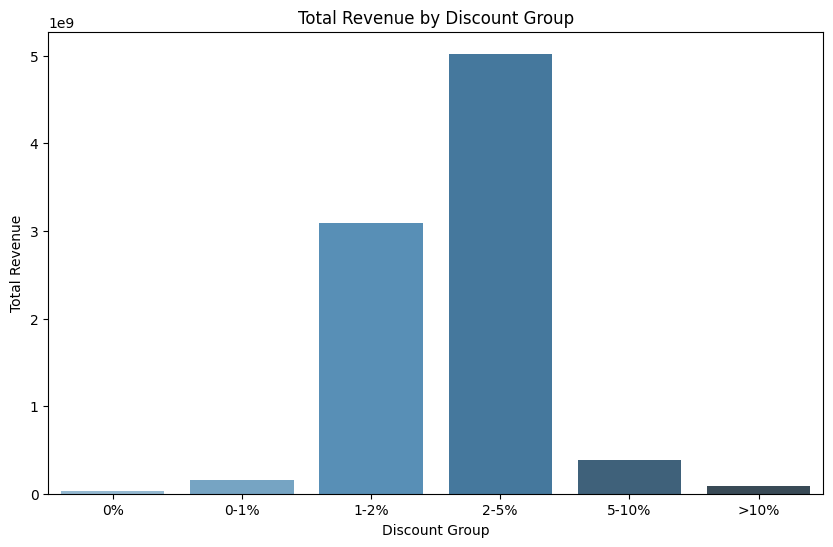

In [19]:
# visualisasi discount analysis dengan bar chart

plt.figure(figsize=(10, 6))
sns.barplot(data=df_disc, x='Disc_Group', y='Total_Revenue', palette='Blues_d')
plt.title('Total Revenue by Discount Group')
plt.xlabel('Discount Group')
plt.ylabel('Total Revenue')
plt.show()

In [20]:
# revenue total, discount percentage, avg order value per transaction, total sales quantity

query_financial_metrics = """
SELECT
    SUM(GROSS_TRADE) AS total_revenue,
    (SUM(DISC_TRADE) * 100.0 / SUM(GROSS_TRADE)) AS discount_percentage,
    AVG(GROSS_TRADE - DISC_TRADE) AS avg_order_value,
    SUM(SALES_QTY) AS total_sales_quantity
FROM database;
"""

result_financial_metrics = pd.read_sql_query(query_financial_metrics, engine)
print(result_financial_metrics)

   total_revenue  discount_percentage  avg_order_value  total_sales_quantity
0     9043219910             2.963884    149990.416563                165859


# 📊 Executive Summary & Strategic Insights: EMOS B2B Performance (Jan - Jun 2025)

## 1. 📉 Revenue Volatility

* **Temuan:** Kinerja penjualan mencapai puncak tertinggi di **Maret (Rp 1.8 Miliar)** namun mengalami penurunan drastis sebesar **~33% di bulan April** (anjlok ke Rp 1.18 Miliar). Tren kembali pulih perlahan di Mei-Juni.
* **Analisis:** Penurunan tajam di awal Q2 (April) mengindikasikan adanya **Seasonal Impact** (kemungkinan libur panjang/Lebaran) atau isu **Stockout** pasca-puncak penjualan Q1.
* **Rekomendasi:**
* Lakukan *forecasting* inventory lebih agresif di bulan Februari untuk mencegah *stockout* di Maret/April.
* Terapkan promo **"Pre-Order Lebaran"** atau bundling khusus di bulan April untuk menjaga momentum cashflow saat *traffic* turun.



## 2. 💊 Product Concentration & Pricing Anomaly

* **Temuan:** Penjualan sangat bergantung pada 3 item utama (**Item C, A, dan D**) yang mendominasi volume penjualan. Sebaliknya, Item F, M, dan I memiliki performa terendah (+- 5k units).
* **Pricing Integrity (Logic Outlier):** Ditemukan variasi harga yang tidak konsisten pada **Item P** (selisih harga ~Rp 8.000 antar transaksi). Setelah ditelusuri, harga tertinggi terjadi di area Indonesia Timur (Sorong/Jayapura) dan terendah di Jawa.
* **Rekomendasi:**
* **Diversifikasi:** Buat program *bundling* (Item A + Item F) untuk mendongkrak stok item *slow moving*.
* **System Lock:** Pastikan variasi harga Item P terkunci by system per *Region* untuk mencegah *human error* input harga yang bisa merugikan margin.



## 3. 🏪 Channel Shift

* **Temuan:** **Apotek** masih menjadi kontributor utama. Namun, terjadi fenomena unik di mana **Toko Kelontong (General Trade)** menempati peringkat ke-6, mengalahkan Toko Obat konvensional.
* **Analisis:** Ini menandakan pergeseran perilaku pasar di mana produk farmasi *Over-the-Counter* (OTC) makin laku di jalur distribusi FMCG (warung/kelontong), bukan hanya di kanal kesehatan khusus.
* **Rekomendasi:**
* **New Frontier:** Fokuskan tim sales untuk penetrasi lebih dalam ke segmen *Toko Kelontong* dan *Mini Market Lokal* karena *Barrier to Entry*-nya lebih rendah dibanding RS/Klinik, namun volumenya masif.



## 4. 📍 Geographic Strategy: Unlocking the "Jabodetabek Cluster"

* **Temuan:** Secara cabang individual, **Bandung, Makassar, dan Tangerang** adalah Top 3 Revenue. Namun, Jabodetabek terlihat lemah karena tidak berada di TOP 5 Cabang (Jakarta-1, Jakarta-2,Bogor, Depok, Bekasi).
* **Analisis:** Jika diagregasi, potensi market **Jabodetabek** Seharusnya lebih dari itu dan Pemisahan manajemen cabang membuat fokus terpecah.
* **Rekomendasi:**
* Terapkan strategi **"Jabodetabek Push Sales"**. Gabungkan Nama cabang perkota dan tingkatat penjualan dengan promo atau bundling di daerah JABODETABEK.



## 5. 👥 Customer Intelligence (RFM Analysis)

Berdasarkan analisis perilaku pelanggan (*Recency, Frequency, Monetary*), pelanggan terbagi menjadi:

* 🏆 **Champions (VIP):** Pelanggan yang baru saja beli, sering beli, dan nilainya besar.
* *Action:* Berikan *Priority Service* atau akses stok eksklusif agar tidak pindah ke kompetitor.


* ⚠️ **At Risk (Perlu Perhatian):** Pelanggan dengan nilai transaksi besar di masa lalu, tapi **sudah lama tidak order**.
* *Action:* Tim Sales wajib melakukan *Direct Call/Visit*. Tanyakan kendala mereka (apakah harga kalah saing? atau kecewa layanan?). follow up ke mereka segera.


* 💤 **One-Time Buyers:** Sekitar **~31%** pelanggan hanya bertransaksi 1x dalam 6 bulan.
* *Action:* Kirimkan voucher diskon khusus pembelian kedua untuk memancing *habit* pembelian rutin.



## 6. 🏷️ Discount Effectiveness Strategy

* **Temuan:**
* Diskon **2% - 5%** menghasilkan total revenue tertinggi (Sweet Spot).
* Diskon **>10%** efektif menaikkan rata-rata nilai keranjang (*Basket Size*) secara signifikan.


* **Rekomendasi:**
* Gunakan diskon kecil (2-5%) untuk produk *fast-moving* (rutin).
* Gunakan diskon besar (>10%) **HANYA** untuk program *Bulk Buying/Grosir* (misal: "Beli 10 Karton, Diskon 12%") untuk menghabiskan stok gudang (*clearance*) tanpa merusak harga pasar eceran.



---

### 📝 Key Metrics Recap (Jan - Jun 2025)

| Metric | Value | 
| --- | --- | 
| **Total Revenue** | **> Rp 9 Miliar** | 
| **Avg. Discount** | **2.53%** | 
| **Avg. Order Value** | **Rp 149.990** | 
| **Sales Quantity** | **~160.000 Unit** | 
| **Repeat Rate** | **~71.9%** | 